In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

import os
try:
    os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\celldyn_embedder")
except FileNotFoundError:
    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    

import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pacmap
import umap
import trimap

from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans

from utils import poincarre_dist
from quality_metrics import CDEmbeddingPerformance
import numpy.linalg as la
import torch 

from numba import njit

import faiss




In [31]:
[c for c in celldyn_full.columns if "id" in c.lower()]

['studyid_alle_celldyn', 'fcs_id', 'opid', 'specid']

In [4]:
celldyn_full = pd.read_feather("L:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_cleaned_transformed_imputed_ALL_with_ratios.feather")
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

In [3]:
len(celldyn_full)

2241484

In [16]:
embedder_full = umap.UMAP(n_components=6,metric = poincarre_dist,n_neighbors=50,min_dist = 0.0,n_jobs=4,n_epochs=400)
le_pipe = Pipeline([('scaler', StandardScaler()),
                    ('embedder', embedder_full)])

le_pipe.fit(celldyn_full[meas_columns]) # final_columns

c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\umap\umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\umap\spectral.py:342: UserWarning: Exited at iteration 20 with accuracies 
[0.0052818  0.0091958  0.00836596 0.01329405 0.01335001 0.01767853
 0.01949975]
not reaching the requested tolerance 1e-08.
  eigenvalues, eigenvectors = scipy.sparse.linalg.lobpcg(


Pipeline(steps=[('scaler', StandardScaler()),
                ('embedder',
                 UMAP(metric=CPUDispatcher(<function poincarre_dist at 0x0000027BF8E93700>), min_dist=0.0, n_components=6, n_epochs=400, n_jobs=4, n_neighbors=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])

In [15]:
le_pipe.named_steps.embedder.n_epochs

In [19]:
import joblib

joblib.dump(le_pipe,'L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/embedded_celldyn_pipe_nn50_ndim6.pkl')

['L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/embedded_celldyn_pipe_nn50_ndim6.pkl']

In [7]:
import joblib

embedder = joblib.load('L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/embedded_celldyn_pipe_nn50_ndim6.pkl')

In [17]:
embedded_data = pd.DataFrame(le_pipe.named_steps['embedder'].embedding_,columns=[f'dim_{i+1}' for i in range(le_pipe.named_steps['embedder'].embedding_.shape[1])])

In [7]:
embedded_data.to_feather("L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/embedded_celldyn_nn50_ndim6_ALL.feather")

### load in data again

##### add patient id, age, sex, time

In [23]:
embedded_data = pd.read_feather("L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/embedded_celldyn_nn50_ndim6_ALL.feather")

In [ ]:
embedded_data

In [25]:

embedded_data['sex'] = celldyn_full.gender
embedded_data['age'] = celldyn_full.age
embedded_data['study_id'] = celldyn_full.studyid_alle_celldyn
embedded_data['analysis_dt'] = celldyn_full.asp_dt
embedded_data['sample_dt'] = celldyn_full.afname_dt


In [22]:
embedded_data.to_feather("L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/embedded_celldyn_ALL_nn50_ndim6_w_labels_.feather")

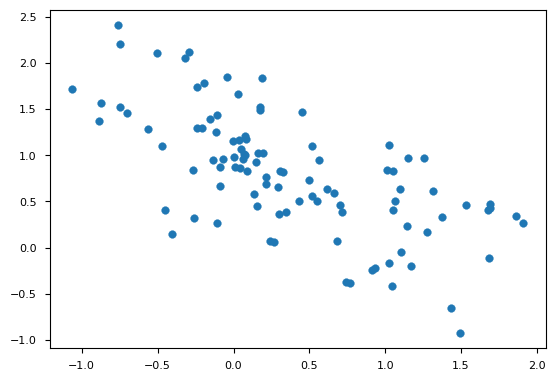

In [31]:
plt.scatter(embedded_data.iloc[0:100,1],le_pipe.named_steps.embedder.embedding_[0:100,1])

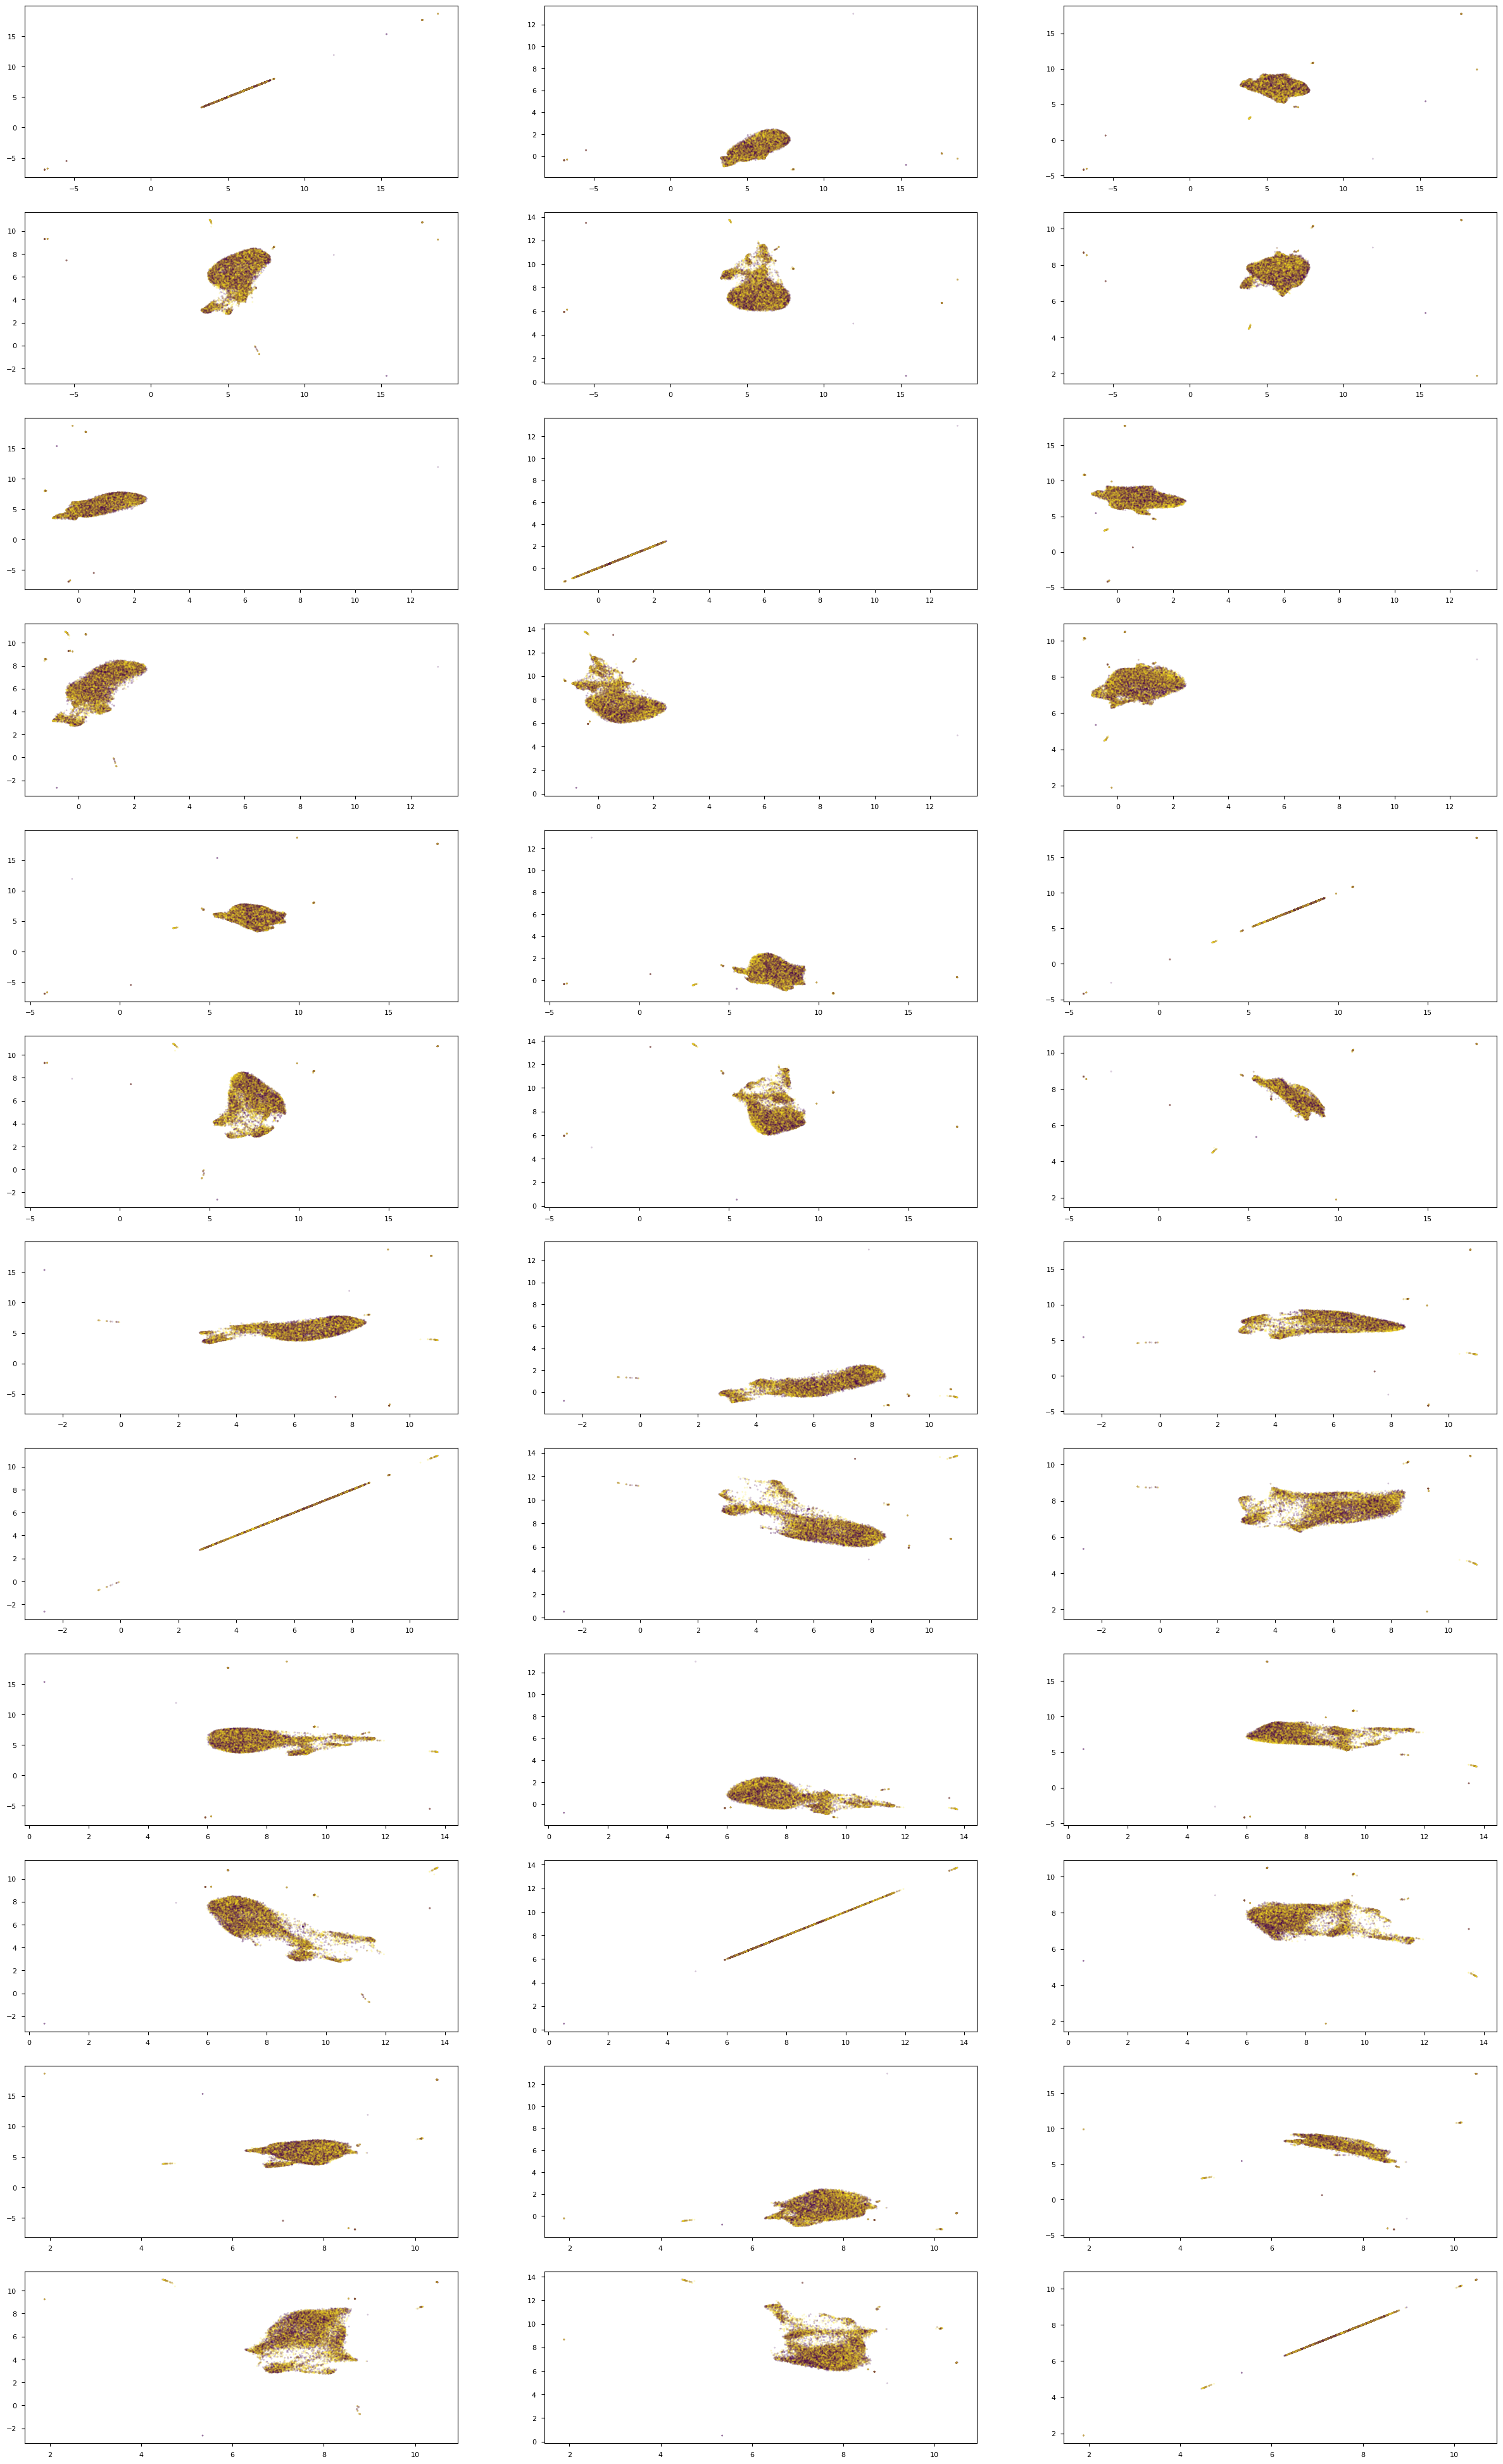

In [32]:
plt.style.use("seaborn-paper")

plot_df = pd.DataFrame(le_pipe.named_steps.embedder.embedding_,columns = [f'dim_{i}' for i in range(1,7)]).sample(20000)
plot_df['sex'] = celldyn_full.gender

fig, ax = plt.subplots(12,3,figsize = (30,50))
i,j = 0,0

for colx in plot_df[[c for c in embedded_data if 'dim' in c]]:
    for coly in plot_df[[c for c in embedded_data if 'dim' in c]]:
        ax[i,j].scatter(plot_df[colx],plot_df[coly], s = 3, alpha = 0.2,c = (plot_df.sex == "M"))
        i = i+1 if j == 2 else i
        j = j+1 if j < 2 else 0
        
